In [1]:
import matplotlib.pyplot as plt
import plotly.offline as py
import numpy  as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

In [2]:
from histimator.models import HistiModel, HistiChannel, HistiSample
from histimator import models
from histimator.estimator import BinnedLH

from probfit import gen_toy
from iminuit import Minuit, describe
from pprint import pprint

In [3]:
def theory_model(x, mu):
    """poisson pdf, parameter lamb is the fit parameter"""
    return mu*st.norm(4,scale=1).pdf(x) + (1-mu)*st.expon(scale=4).pdf(x)

In [4]:
ff = 0.3 
np.random.seed(42)

bounds  = (0, 10)
xbin    = np.linspace(0,10,21)
data    = np.random.poisson(1000*theory_model(xbin, ff))
hist_s  = np.random.poisson(1000*ff*st.norm(4,scale=1).pdf(xbin)).astype(np.float64)
hist_b  = np.random.poisson(1000*(1-ff)*st.expon(scale=4).pdf(xbin)).astype(np.float64)
binedge = xbin-np.diff(xbin)[0]/2.0 
binedge = np.append(binedge, [xbin.max() + np.diff(xbin)[0]/2.0])

In [5]:
m = HistiModel('model')

signal = HistiSample("signal")
signal.SetHisto((hist_s, binedge))
signal.AddNorm("SigXSecOverSM", 1.0,0,3)

background = HistiSample("background1")
background.SetHisto((hist_b, binedge))

chan = HistiChannel("SR")
chan.AddSample(signal)
chan.AddSample(background)

m.AddChannel(chan)
chan.SetData(data)
m.AddChannel(chan)

In [6]:
def plot_model(model,true_mu=1.0, fitted_mu=None):
    plt.figure(figsize=(5,5))
    t = np.linspace(0,10,1000)
    pred = np.asarray([model.pdf(i, true_mu)*0.5 for i in t])
    plt.plot(t, pred, color='black', label='model')
    plt.errorbar(
        xbin, data, yerr=np.sqrt(data), fmt='.', ms=14, capsize=0, color='black', label='data'
    )
    if fitted_mu is not None:
        pred_fitted = np.asarray([model.pdf(i, fitted_mu)*0.5 for i in t])
        plt.plot(t, pred_fitted, color='green', label='fitted pdf')
    plt.xlabel('X (obs)')
    plt.ylabel('dN/dX')
    plt.legend()

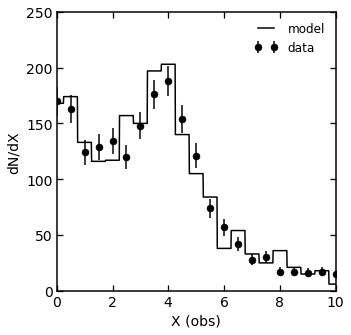

In [7]:
plot_model(m)

In [8]:
print "---- printing model --- "
pprint (chan.__dict__)
for n_, s_ in chan.__dict__['samples'].items():
    print '---- sample : ', n_
    pprint (s_.__dict__)
print "---------------------------- "

---- printing model --- 
{'data': array([170, 163, 124, 129, 134, 120, 148, 176, 188, 154, 121,  74,  57,
        42,  28,  30,  17,  17,  16,  17,  15]),
 'n_samples': 2,
 'name': 'SR',
 'samples': {'background1': <histimator.models.HistiSample object at 0x115abd290>,
             'signal': <histimator.models.HistiSample object at 0x115abd110>}}
---- sample :  signal
{'bincontent': array([  0.,   0.,   0.,   5.,  17.,  45.,  64., 116., 127.,  87.,  61.,
        41.,   8.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'binedges': array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,
        4.25,  4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,
        8.75,  9.25,  9.75, 10.25]),
 'hist': (array([  0.,   0.,   0.,   5.,  17.,  45.,  64., 116., 127.,  87.,  61.,
        41.,   8.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
          array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,
        4.25,  4.75,  5.25,  5.75,  6.25,  6.75,  

In [10]:
blh = BinnedLH(m, bound=bounds, extended=True)

In [12]:
minimiser = Minuit(blh, SigXSecOverSM=1.0, limit_SigXSecOverSM  =(0,  2),
                   error_SigXSecOverSM=0.1, errordef=1)
minimiser.migrad()
minimiser.minos()
print 'migrad gives SigXSecOverSM as value', minimiser.values['SigXSecOverSM']

FCN = 96.9627680496 
 TOTAL NCALL = 16 
 NCALLS = 16 
 
 
 EDM = 5.74004109496e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,SigXSecOverSM,0.937867,0.0639375,0,0,0.0,2.0,


Error,-0.0633669045931,0.0645928692098
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


migrad gives SigXSecOverSM as value 0.937867304617


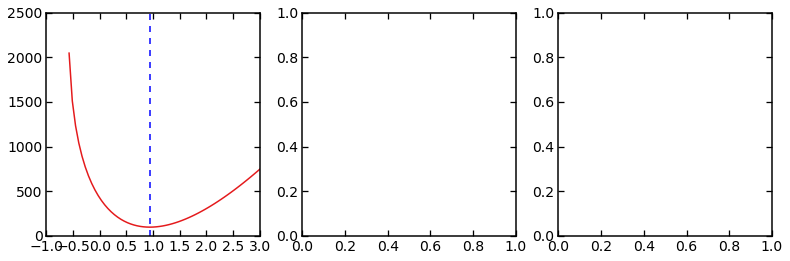

In [13]:
fig, ax = plt.subplots(1,3,figsize=(13,4))
t = np.linspace(-3,3, 100)
ax[0].plot(t, [blh(i) for i in t])
ax[0].axvline(minimiser.values['SigXSecOverSM'], ls='--')

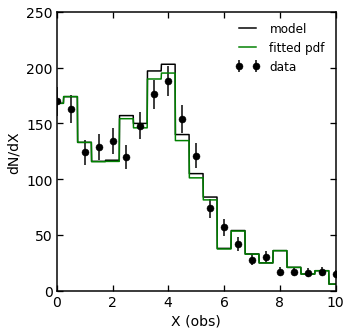

In [14]:
plot_model(m, 1.0, fitted_mu=minimiser.values['SigXSecOverSM'])